# Linear regression for causal treatment effects

Quick exploration into regression coefficients in the presence of confounders and colliders.

Outline:
*   Generate random linear data
*   Estimate treatment effects with regression models
*   Repeat in the presence on confounder variables
*   Repeat in the presence on collider variables

## Generate random data

I'll make random data from two beta distributions and then select from them randomly to get two peaks.
I'll deliberately make the distributions fairly distinct to make the initial analysis easier to visualise.

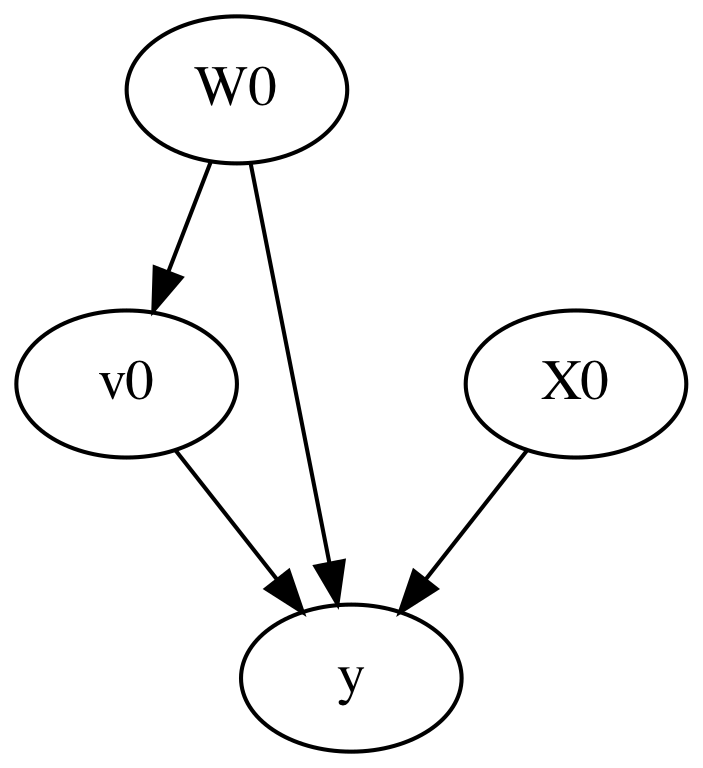

In [1]:
import dowhy
import dowhy.datasets
from IPython.display import Image, display
import numpy as np
import pandas as pd

np.random.seed(0)

data = dowhy.datasets.linear_dataset(
    beta=10,
    num_common_causes=1,
    num_effect_modifiers=1,
    num_treatments=1,
    num_samples=10000,
    treatment_is_binary=True)

model= dowhy.CausalModel(
        data = data['df'],
        graph=data['dot_graph'],
        treatment='v0',
        outcome='y')
        # treatment=data['treatment_name'],
        # outcome=data['outcome_name'])
model.view_model()
display(Image(filename="causal_model.png"))

In [2]:
data

{'df':             X0        W0     v0          y
 0     1.425796  0.839219   True  16.155176
 1     0.829630  1.650541   True  19.222578
 2     0.641454 -2.170701  False -10.571212
 3     0.464593  1.431172   True  17.613207
 4    -2.890673 -0.745097  False  -3.607522
 ...        ...       ...    ...        ...
 9995 -1.769780 -2.566124  False -12.473948
 9996  0.565630  0.620036   True  13.829555
 9997  0.842816  0.705027   True  14.644854
 9998  0.317744 -1.866780   True   1.412901
 9999  0.116563  0.097260  False   0.481037
 
 [10000 rows x 4 columns],
 'treatment_name': ['v0'],
 'outcome_name': 'y',
 'common_causes_names': ['W0'],
 'instrument_names': [],
 'effect_modifier_names': ['X0'],
 'frontdoor_variables_names': [],
 'dot_graph': 'digraph {v0->y;W0-> v0;W0-> y;X0-> y;}',
 'gml_graph': 'graph[directed 1node[ id "y" label "y"]node[ id "W0" label "W0"]node[ id "v0" label "v0"]edge[source "v0" target "y"]edge[ source "W0" target "v0"]edge[ source "W0" target "y"]node[ id "X0" la

In [3]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d           
─────(E[y|W0])
d[v₀]         
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,U) = P(y|v0,W0)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [4]:
# fit linear regression
# S-Learner
import statsmodels.api as sm

df_train = data['df'].astype(float)
model = sm.OLS(endog=df_train['y'], exog=df_train.drop(columns=['y']))
# model = sm.OLS(endog=df_train['y'], exog=df_train.drop(columns=['y','propensity_score']))
model_params = model.fit()

print('True effect size: ', data['ate'])
model_params.summary()

True effect size:  9.88884743969195


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                          5.919e+05
Date:                Sat, 23 Apr 2022   Prob (F-statistic):                        0.00
Time:                        23:10:14   Log-Likelihood:                         -10926.
No. Observations:               10000   AIC:                                  2.186e+04
Df Residuals:                    9997   BIC:                                  2.188e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X0             0.7435      0.007    102.450      0.000       0.729       0.758
W0             4.8539      0.007    650.073      0.000       4.839       4.869
v0             9.9470      0.010    952.737      0.000       9.927       9.967
==============================================================================
Omnibus:                        1.542   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.462   Jarque-Bera (JB):                1.534
Skew:                           0.006   Prob(JB):                        0.464
Kurtosis:                       3.059   Cond. No.                         1.55
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
import causalml
import causalml.inference.meta
# causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
# from causalml.dataset.regression import synthetic_data
import sklearn.linear_model



# Load synthetic data
# y, X, treatment, tau, b, e = synthetic_data(mode=1, n=10000, p=25, sigma=0.5)
# w_multi = np.array(['treatment_A' if x==1 else 'control' for x in treatment]) # customize treatment/control names

# slearner = causalml.inference.meta.BaseSRegressor(LGBMRegressor(), control_name='control')
slearner = causalml.inference.meta.BaseSRegressor(sklearn.linear_model.LinearRegression(), control_name='control')
model = sm.OLS(endog=df_train['y'], exog=df_train.drop(columns=['y']))
slearner.estimate_ate(df_train.drop(columns=['y','v0']), df_train['v0'], df_train['y'])
slearner_tau = slearner.fit_predict(df_train.drop(columns=['y','v0']), df_train['v0'], df_train['y'])

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


AssertionError: Control group level control not found in treatment vector.

In [8]:
from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor
from causalml.inference.meta import BaseRRegressor, BaseSRegressor
from xgboost import XGBRegressor
from causalml.dataset import synthetic_data

y, X, treatment, _, _, e = synthetic_data(mode=1, n=1000, p=5, sigma=1.0)

lr = LRSRegressor()
te, lb, ub = lr.estimate_ate(X, treatment, y)
print('Average Treatment Effect (Linear Regression): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

xg = XGBTRegressor(random_state=42)
te, lb, ub = xg.estimate_ate(X, treatment, y)
print('Average Treatment Effect (XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

nn = MLPTRegressor(hidden_layer_sizes=(10, 10),
                 learning_rate_init=.1,
                 early_stopping=True,
                 random_state=42)
te, lb, ub = nn.estimate_ate(X, treatment, y)
print('Average Treatment Effect (Neural Network (MLP)): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

xl = BaseXRegressor(learner=XGBRegressor(random_state=42))
te, lb, ub = xl.estimate_ate(X, treatment, y, e)
print('Average Treatment Effect (BaseXRegressor using XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

rl = BaseRRegressor(learner=XGBRegressor(random_state=42))
te, lb, ub =  rl.estimate_ate(X=X, p=e, treatment=treatment, y=y)
print('Average Treatment Effect (BaseRRegressor using XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

sl = BaseSRegressor(learner=XGBRegressor(random_state=42))
te, lb, ub =  sl.estimate_ate(X=X, p=e, treatment=treatment, y=y)
print('Average Treatment Effect (BaseRRegressor using XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))


Average Treatment Effect (Linear Regression): 0.75 (0.60, 0.90)
Average Treatment Effect (XGBoost): 0.66 (0.58, 0.73)
Average Treatment Effect (Neural Network (MLP)): 0.77 (0.64, 0.89)
Average Treatment Effect (BaseXRegressor using XGBoost): 0.60 (0.55, 0.65)


/Users/Rich/Developer/miniconda3/envs/causal_inf_env/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/Rich/Developer/miniconda3/envs/causal_inf_env/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Average Treatment Effect (BaseRRegressor using XGBoost): 0.72 (0.72, 0.73)


ValueError: not enough values to unpack (expected 3, got 1)

In [14]:

y, X, treatment, tau, b, e = synthetic_data(mode=1, n=10000, p=8, sigma=1.0)
treatment
X.shape
e

array([0.63836668, 0.51980927, 0.9       , ..., 0.9       , 0.46727376,
       0.39913776])

In [16]:

sl = BaseSRegressor(learner=XGBRegressor(random_state=42))
te =  sl.estimate_ate(X=X, p=e, treatment=treatment, y=y)
print('Average Treatment Effect (BaseRRegressor using XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], te[1], te[2]))


IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
# propensity matching

In [ ]:
# inverse propensity weighting

In [ ]:
# fit with double ML

In [27]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_matching")
print(estimate)

propensity_score_matching


/Users/Rich/Developer/miniconda3/envs/causal_inf_env/lib/python3.10/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d           
─────(E[y|W0])
d[v₀]         
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,U) = P(y|v0,W0)

## Realized estimand
b: y~v0+W0
Target units: ate

## Estimate
Mean value: 11.213763378853265



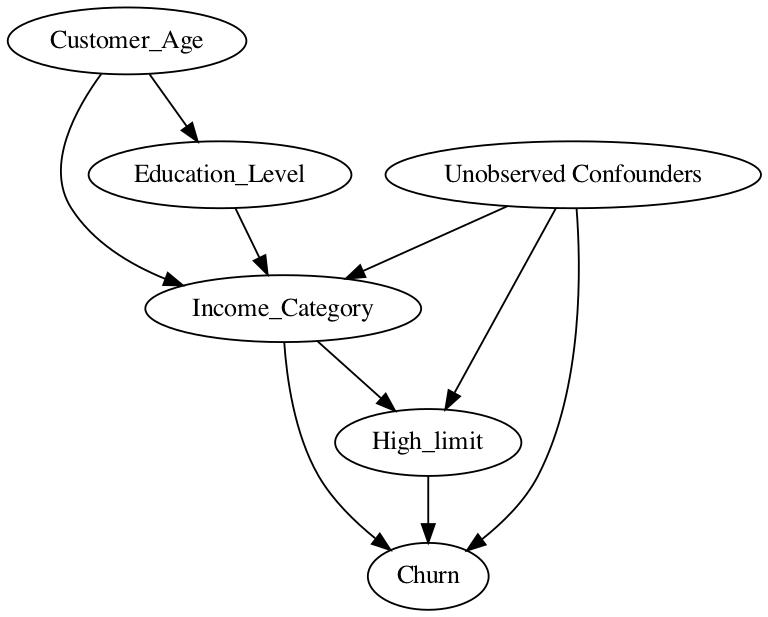

In [3]:
from dowhy import CausalModel
from IPython.display import Image, display

causal_graph = """
digraph {
High_limit;
Churn;
Income_Category;
Education_Level;
Customer_Age;
U[label="Unobserved Confounders"];
Customer_Age -> Education_Level; Customer_Age -> Income_Category;
Education_Level -> Income_Category; Income_Category->High_limit;
U->Income_Category;U->High_limit;U->Churn;
High_limit->Churn; Income_Category -> Churn;
}
"""

model= CausalModel(
        data = pd.DataFrame(),
        graph=causal_graph.replace("\n", " "),
        treatment='High_limit',
        outcome='Churn')
model.view_model()
display(Image(filename="causal_model.png"))